# Sơ đồ hệ thống

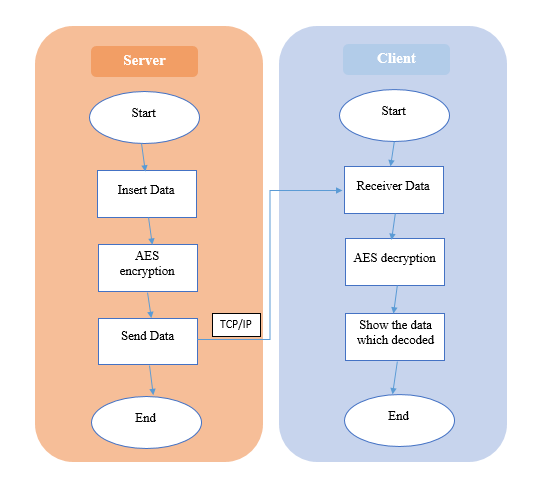

### Cài các thư viện cần thiết

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import socket
import numpy as np
from hashlib import md5
from Crypto.Cipher import AES
import os
import glob
import time
from Crypto import Random
from os import urandom
import tkinter as tk
from tkinter import *

### Dùng socket kết nối tới Server 

In [3]:
HOST='localhost'
PORT=8000
# WIDTH = 960
# HEIGHT = 540
SC = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
server_address = (HOST, PORT)

### Tạo các hàm cần dùng để nhận dữ liệu, tạo folder mới và hàm connect

In [4]:
def generateAESKey(key_string, len_key):
    '''Generate 128/192/256 bit key from any key'''
    key = bytes(key_string,"utf8")
    while len(key)<len_key:
        key = key + key
    return key[:len_key]

def make_folder(folder_name):
    path_f = os.path.abspath('')
    if os.path.isdir(path_f+"/"+folder_name) == False:
        os.mkdir(path_f+"/"+folder_name)
    list_folder = glob.glob(path_f+"/"+folder_name+"/*")
    max=0
    for i in list_folder:
        try:
            num = int(i.split("-")[1])
            if(max<num): max = num
        except: continue
    path = path_f+"/"+folder_name+"/data-"+str(max+1)
    os.mkdir(path)
    return path

# connect to client
def connect(sc, server_address):
    print("Connecting to the server...")
    while True:
        try:
            sc.connect(server_address)
            break
        except:
            ()
    print("[Connected]", server_address)
    return sc

### Tạo hàm để mã hóa và giải mã AES

In [5]:
def derive_key_and_iv(key, salt, key_length, iv_length):
    d = d_i = b''
    while len(d) < key_length + iv_length:
        d_i = md5(d_i + key + salt).digest()
        d += d_i
    return d[:key_length], d[key_length:key_length+iv_length]

def encrypt(in_file, out_file, key, key_length=32):
    bs = AES.block_size #16 bytes
    salt = urandom(bs) #return a string of random bytes
    key, iv = derive_key_and_iv(key, salt, key_length, bs)
    cipher = AES.new(key, AES.MODE_CBC, iv)
    out_file.write(salt)
    finished = False

    while not finished:
        chunk = in_file.read(1024 * bs) 
        if len(chunk) == 0 or len(chunk) % bs != 0:#final block/chunk is padded before encryption
            padding_length = (bs - len(chunk) % bs) or bs
            chunk += str.encode(padding_length * chr(padding_length))
            finished = True
        out_file.write(cipher.encrypt(chunk))
        
def decrypt(in_file, out_file, key, key_length=32):
    bs = AES.block_size
    salt = in_file.read(bs)
    key, iv = derive_key_and_iv(key, salt, key_length, bs)
    cipher = AES.new(key, AES.MODE_CBC, iv)
    next_chunk = ''
    finished = False
    while not finished:
        chunk, next_chunk = next_chunk, cipher.decrypt(in_file.read(1024 * bs))
        if len(next_chunk) == 0:
            padding_length = chunk[-1]
            chunk = chunk[:-padding_length]
            finished = True 
        out_file.write(bytes(x for x in chunk)) 

In [6]:
 # Create folder to save data
save_path = make_folder("Client_folder")

### Tạo hàm nhận và xử lý file nhận được từ Server 

In [7]:
def RecvMess(sc, key):
    print("Waiting for Server...")
    
   
    
    #Receive data
    data_enc = sc.recv(1024)
    s_time = time.time()   
    sc.send(b"Done")
#     print(len(data_enc))
    
    
    # Save Data
    f_data_enc = open(save_path+"/Data-received-from-server.txt", "wb")
    f_data_enc.write(data_enc)
    f_data_enc.close()
    rec_time = time.time()
    print(" - Received data: %d KB (%.3f seconds)" %(int(len(data_enc)/1024),rec_time-s_time))

    # Decode Data
    in_file= open(save_path+"/Data-received-from-server.txt", "rb") 
    out_file = open(save_path+"/Data-decoded.txt", "wb")
    decrypt(in_file, out_file, key)                             #decode
    in_file.close()
    out_file.close()
    aes_time =  time.time()
    print(" - Decoded AES. (%.3f seconds)" )
    

### Hàm main

In [8]:
key = "Group_6"

key_AES = generateAESKey(key, 16) # create AES key (128bit)
print("Your AES key: ", key_AES)

Your AES key:  b'Group_6Group_6Gr'


In [9]:
SC = connect(SC, server_address)

Connecting to the server...
[Connected] ('localhost', 8000)


In [10]:
RecvMess(SC, key_AES)

Waiting for Server...
 - Received data: 0 KB (0.001 seconds)
 - Decoded AES. (%.3f seconds)


### Tạo của sổ hiển thị dữ liệu bằng tkinter

In [11]:
window = Tk()
window.title('Client Window')
window.geometry('600x600')

label = Label(window, text = "What u want to see ?", font = ('Arial', 10))
label.place(x = 30, y = 20)
# entry = Entry(window, width = 20, font = ('Arial', 10))
# entry.place(x=30, y = 50)
textBox=Text(window , height=4, width=50)
textBox.place(x=30, y = 150)
def data_rec():
    f_data_rec = open(save_path+"/Data-decoded.txt", "r")
    data_rec = f_data_rec.read()
    f_data_rec.close()
    return data_rec
def data_enc():
    f_data_enc = open(save_path+"/Data-received-from-server.txt", "rb")
    data_enc = f_data_enc.read()
    f_data_enc.close()
    return data_enc
    
def button_command1():
    data = data_rec()
    textBox.insert('end',data)
    pass
# def button_command2():
#     data = data_enc()
#     textBox.insert('end',data)
#     pass


button1 = Button(window, text = "After decode", width = 10, height = 2, command = button_command1)
button1.place(x = 40, y = 50)
# button2 = Button(window, text = "Before decode", width = 10, height = 2, command = button_command2)
# button2.place(x = 60, y = 50)

#Lặp vô tận để hiển thị cửa sổ
window.mainloop()

In [12]:
SC.close()